# Assignment 2
Hvis objektet fortrenger like mye vann som sin egen vekt, vil det ligge i ro.


$$
\begin{aligned}
\\
\frac{\rho_{pipe}}{\rho_{water}} &= 1\\
\\
m_{inside} \approx 0 \implies  \frac{m_{cf}}{m_{water}} &= 1\\
\\
\frac{\pi(D^2-d^2) L \rho_{cf}}{\pi D^2 L \rho_{water}} &= 1\\
\\
\frac{D^2 - d^2}{D^2} &= \frac{\rho_{water}}{\rho_{cf}}\\
\\
\frac{d}{D} &= \sqrt{1 - \frac{\rho_{water}}{\rho_{cf}}}
\end{aligned}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Constants
MAX_DIAMETER = 25 # mm
RHO_W = 1000 # kg/m^3 
EXTERNAL_PRESSURE = 100 # MPa

In [ ]:
# Functions

def get_inner_diameter(D, rho_w, rho_material):
    return np.sqrt(1- (rho_w/rho_material)) * D


def calculate_pipe_pressure_stresses(Pi, Po, ri, ro, num_points=100):
   
    r_values = np.linspace(ri, ro, num_points)  # Radielle punkter
    
    # Beregn A og B
    A = (Pi * ri**2 - Po * ro**2) / (ro**2 - ri**2)
    B = (Pi - Po) * ri**2 * ro**2 / (ro**2 - ri**2)
    
    # Beregn spenningene
    sigma_r = A - B / r_values**2
    sigma_theta = A + B / r_values**2
    
    return r_values, sigma_r, sigma_theta


def plot_max_stress(material, r, sigma_1, sigma_2):
    #Data points for the rectangle in the s1-s2 plane
    s1=(material['XT'],-material['XC'],-material['XC'],material['XT'],material['XT'])
    s2=(material['YT'],material['YT'],-material['YC'],-material['YC'],material['YT'])
    fig,ax = plt.subplots(figsize=(10,5))
    ax.plot(s1,s2,'--',color='blue',linewidth=1)

    #Origo
    ax.plot((0,),(0,),'+',color='black',markersize=50)

    # Plot points
    ax.plot(sigma_1, sigma_2, color='red')

    # Add text for min and max radial pos
    ax.text(sigma_1[0], sigma_2[0], f'  r_min = {r[0]:.2f}', fontsize=14)
    
    ax.text(sigma_1[-1], sigma_2[-1], f'  r_max = {r[-1]:.2f}', fontsize=14)
    

    ax.set_xlabel(r'$\sigma_1$',fontsize=14)
    ax.set_ylabel(r'$\sigma_2$',fontsize=14)
    ax.grid(True)
    plt.tight_layout()


def fE_tsaiwu(s,m):
    s1,s2,s3,s23,s13,s12=s[0],s[1],s[2],s[3],s[4],s[5]
    XT,YT,ZT,XC,YC,ZC,S12,S13,S23 = m['XT'], m['YT'], m['ZT'], m['XC'], m['YC'], m['ZC'], m['S12'], m['S13'], m['S23']
    f12, f13, f23 = m['f12'], m['f13'], m['f23']
    F1,  F2,  F3  = (1/XT)-(1/XC) , (1/YT)-(1/YC) , (1/ZT)-(1/ZC)
    F11, F22, F33 =     1/(XT*XC) ,     1/(YT*YC) ,     1/(ZT*ZC)
    F44, F55, F66 =    1/(S23**2) ,    1/(S13**2) ,     1/(S12**2)
    F12 = f12*(F11*F22)**0.5
    F13 = f13*(F11*F33)**0.5
    F23 = f23*(F22*F33)**0.5
    a=F11*(s1**2) + F22*(s2**2) + F33*(s3**2)+ 2*(F12*s1*s2 + F13*s1*s3 + F23*s2*s3)+\
    F44*(s23**2) + F55*(s13**2) + F66*(s12**2)
    if a==0:
        return 0
    b=F1*s1 + F2*s2 +F3*s3
    c=-1
    R=(-b+(b**2-4*a*c)**0.5)/(2*a)
    fE=1/R
    return fE

def fE_maxstress(s,m):
    # Using local varibles for easier coding and readability..
    s1,s2,s3,s23,s13,s12=s[0],s[1],s[2],s[3],s[4],s[5]
    XT,YT,ZT,XC,YC,ZC,S12,S13,S23 = m['XT'], m['YT'], m['ZT'], m['XC'], m['YC'], m['ZC'], m['S12'], m['S13'], m['S23']
    fE=max(s1/XT,-s1/XC,s2/YT,-s2/YC,s3/ZT,-s3/ZC,abs(s12/S12),abs(s13/S13),abs(s23/S23))
    return fE

def fE_maxstrain(s,m):
    s1,s2,s3,s23,s13,s12=s[0],s[1],s[2],s[3],s[4],s[5]
    XT,YT,ZT,XC,YC,ZC,S12,S13,S23 = m['XT'],m['YT'],m['ZT'],m['XC'],m['YC'],m['ZC'],m['S12'],m['S13'],m['S23']
    E1,E2,E3,v12,v13,v23,G12,G13,G23=m['E1'],m['E2'],m['E3'],m['v12'],m['v13'],m['v23'],m['G12'],m['G13'],m['G23']
    e1=   (1/E1)*s1 + (-v12/E1)*s2 + (-v13/E1)*s3
    e2=(-v12/E1)*s1 +    (1/E2)*s2 + (-v23/E2)*s3
    e3=(-v13/E1)*s1 + (-v23/E2)*s2 +    (1/E3)*s3
    e23,e13,e12 = s23/G23, s13/G13, s12/G12
    f=max( e1/(XT/E1),-e1/(XC/E1),e2/(YT/E2),-e2/(YC/E2),e3/(ZT/E3),-e3/(ZC/E3),
           abs(e12/(S12/G12)),abs(e13/(S13/G13)),abs(e23/(S23/G23)) )
    return f



def plot_failure_criterias(material, r, sigma_1, sigma_2):
    fig,ax = plt.subplots(figsize=(8,4))

    # empty list of normal stresses in the 1-2 plane:
    s1_MS,s2_MS=[],[]  # maximum stress
    s1_ME,s2_ME=[],[]  # maximum strain

    for a in np.linspace(0, 2*np.pi, 3600):
        s1i=np.cos(a)
        s2i=np.sin(a)

        feMS=fE_maxstress((s1i,s2i,0,0,0,0),material)
        fe_ME=fE_maxstrain((s1i,s2i,0,0,0,0), material)

        # then scaling by the load-proportionality ratio (1/fE):
        s1_MS.append(s1i/feMS)
        s2_MS.append(s2i/feMS)

        s1_ME.append(s1i/fe_ME)
        s2_ME.append(s2i/fe_ME)

    ax.plot(s1_MS,s2_MS,'--',color='black',label='Max Stress',linewidth=1)
    ax.plot(s1_ME,s2_ME,'--',color='blue',label='Max Strain',linewidth=1)
    
    # Making axes through the origo:
    ax.plot((0,),(0,),'+',color='black',markersize=50)
    
    # ---- Plot actual stresses ----

    # Plot points
    ax.plot(sigma_1, sigma_2, color='red')

    # Add text for min and max radial pos
    ax.text(sigma_1[0], sigma_2[0], f'  r_min = {r[0]:.2f}', fontsize=14)
    ax.text(sigma_1[-1], sigma_2[-1], f'  r_max = {r[-1]:.2f}', fontsize=14)



    ax.set_xlabel(r'$\sigma_1$',fontsize=14)
    ax.set_ylabel(r'$\sigma_2$',fontsize=14)
    ax.grid(True)
    plt.tight_layout()

In [18]:
#TODO: fiks enheter
Carbon_EpoxyA = {
    'name': 'Carbon/Epoxy(a)', 
    'rho': 1600, # kg/m3
    'E1': 130, # Pa 
    'E2': 10,
    'E3': 10,

    'XT': 1800,
    'XC': 1200,
    'YT': 40,
    'YC': 180,
    'ZT': 40,
    'ZC': 180,
    'S12': 70,
    'S13': 70,
    'S23': 40,

    'v12': 0.28,
    'v13': 0.28,
    'v23': 0.50,
    'G12': 4.5,
    'G13': 4.5,
    'G23': 3.5
}

Plan: Itterer over ulike ytre diametre, finn nødvendig indre for å oppnå riktig buoyancy. Plot i failure criteria

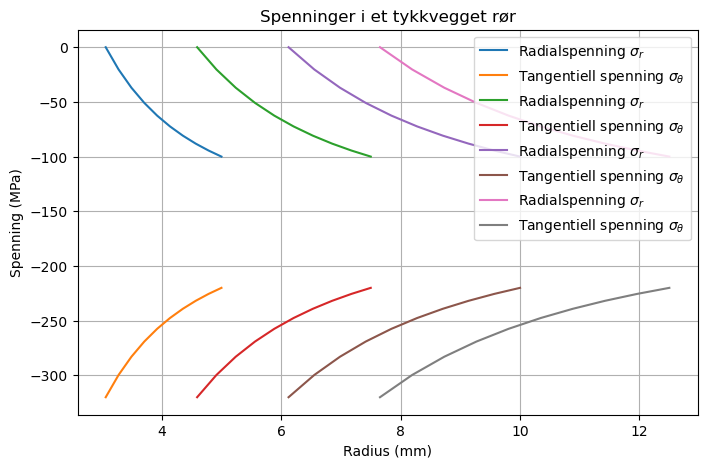

In [46]:
D_start = MAX_DIAMETER * 0.4
D_end = MAX_DIAMETER


# Plot resultater
plt.figure(figsize=(8, 5))

# Save results
pipe_variations = []

# iterate over different outer Diameters
for D in np.linspace(D_start, D_end, 4):

    # Calculate inner diameter for neural buoyancy
    d = get_inner_diameter(D, RHO_W, rho_material=Carbon_EpoxyA['rho'])

    # Save combination
    pipe_variations.append((D, d))
    
    # Get stresses for each position
    r, sigma_r, sigma_theta = calculate_pipe_pressure_stresses(Pi=0, Po=EXTERNAL_PRESSURE, ri=(d/2), ro=(D/2), num_points=10)

    # Plot stresses
    plt.plot(r, sigma_r, label="Radialspenning $σ_r$")
    plt.plot(r, sigma_theta, label="Tangentiell spenning $σ_θ$")

plt.xlabel("Radius (mm)")
plt.ylabel("Spenning (MPa)")
plt.legend()
plt.title("Spenninger i et tykkvegget rør")
plt.grid()
plt.show()

# Plotting failure criterias

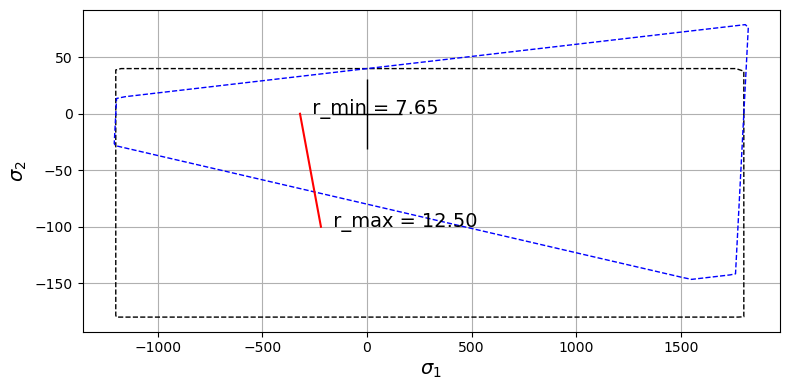

In [73]:
# Get D and d
D = MAX_DIAMETER
d = get_inner_diameter(D, RHO_W, rho_material=Carbon_EpoxyA['rho'])

# Get stresses
r, sigma_r, sigma_theta = calculate_pipe_pressure_stresses(Pi=0, Po=EXTERNAL_PRESSURE, ri=(d/2.0), ro=(D/2.0), num_points=6)

plot_failure_criterias(Carbon_EpoxyA, r, sigma_1=sigma_theta, sigma_2=sigma_r)